# SHAP Demo for Classification with PIMA Diabetes

## Preamble

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = set(('retina', 'svg'))
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = (8,6)
sns.set(
    style='ticks', 
    palette="Paired",
    font_scale=0.8
)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

import shap
shap.initjs()

## Load, Inspect, Prepare Data

In [192]:
pima_df = pd.read_csv('https://raw.githubusercontent.com/gerberl/6g7v0017-2122/main/datasets/diabetes.csv')
pima_df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [22]:
X, y = pima_df.drop(columns='Outcome'), pima_df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [23]:
X.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50


In [24]:
y.head(1)

0    1
Name: Outcome, dtype: int64

In [65]:
pima_df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [66]:
pima_df['Outcome'].unique()

array([1, 0])

In [67]:
pima_df['Outcome'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

## Fit and Inspect a Random Forest (to be explained by SHAP)

In [25]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [145]:
cols_cannot_be_0 = X.columns.drop(['Pregnancies']).tolist()
cols_cannot_be_0

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [155]:
clf = Pipeline(steps=[
    ('pp', ColumnTransformer(
        [
            ('imputer', 
             SimpleImputer(missing_values=0, strategy="mean"),
             cols_cannot_be_0)
        ],
        remainder='passthrough'
    )),
    ('est', RandomForestClassifier())
])
clf.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer',
                                                  SimpleImputer(missing_values=0),
                                                  ['Glucose', 'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age'])])),
                ('est', RandomForestClassifier())])

In [156]:
clf[:-1].get_feature_names_out()

array(['imputer__Glucose', 'imputer__BloodPressure',
       'imputer__SkinThickness', 'imputer__Insulin', 'imputer__BMI',
       'imputer__DiabetesPedigreeFunction', 'imputer__Age',
       'remainder__Pregnancies'], dtype=object)

In [157]:
# couldn't find a better way (rather than removing the prefix of the names
# returned by get_feature_names_out
all_cols = cols_cannot_be_0 + ['Pregnancies']

In [158]:
all_cols

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Pregnancies']

In [159]:
# test transformer
X_train_pp = pd.DataFrame(
    clf.named_steps['pp'].fit_transform(X_train),
    columns=all_cols
)

In [160]:
cross_val_score(clf, X_train, y_train)

array([0.74796748, 0.76422764, 0.69105691, 0.79674797, 0.79508197])

## Initialising and Testing SHAP Explainer and Values

In [161]:
# this instantiates an Explainer object for global and local explanations
# on the Random Forest Model
explainer = shap.TreeExplainer(clf.named_steps['est'])

In [162]:
# we can ask the explainer for the SHAP values on the test data
shap_values = explainer.shap_values(clf.steps[0][1].transform(X_test))

In [163]:
X_test.shape

(154, 8)

In [164]:
shap_values[:2]

[array([[ 0.13280444,  0.01023998,  0.04203804, ...,  0.00426679,
          0.06559071,  0.02315129],
        [-0.24101634,  0.00973992,  0.00691578, ...,  0.01519263,
          0.07593024,  0.02120698],
        [-0.33489158,  0.00411077, -0.03541471, ...,  0.11143031,
          0.09504259,  0.00430975],
        ...,
        [ 0.07842689,  0.00834316,  0.05007699, ...,  0.04526735,
          0.03714998,  0.0048364 ],
        [ 0.05696898, -0.03135572, -0.0611591 , ...,  0.04338641,
          0.12066874,  0.00778826],
        [ 0.10772496, -0.03016452,  0.05378856, ..., -0.00465553,
          0.05063302,  0.01104767]]),
 array([[-0.13280444, -0.01023998, -0.04203804, ..., -0.00426679,
         -0.06559071, -0.02315129],
        [ 0.24101634, -0.00973992, -0.00691578, ..., -0.01519263,
         -0.07593024, -0.02120698],
        [ 0.33489158, -0.00411077,  0.03541471, ..., -0.11143031,
         -0.09504259, -0.00430975],
        ...,
        [-0.07842689, -0.00834316, -0.05007699, ..., -

In [165]:
# for classification models that are multiclass (rather than one-vs-rest)
# there will be a matrix of SHAP values for each class value...
# I will assume we would like to investigate the positive class (has diabetes)
cls_idx = 1

In [166]:
# we can investigate a local explanation with the position index of the instance
# of interest
row_idx = 0

In [167]:
X_test_pp = pd.DataFrame(
    clf.named_steps['pp'].transform(X_test), columns=all_cols
)

In [168]:
X_train['Age'].mean()

33.57328990228013

In [169]:
X_test['Age'].mean()

31.915584415584416

In [170]:
X_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
432,1,80,74,11,60,30.0,0.527,22
391,5,166,76,0,0,45.7,0.340,27
110,3,171,72,33,135,33.3,0.199,24
412,1,143,84,23,310,42.4,1.076,22
23,9,119,80,35,0,29.0,0.263,29


In [171]:
X_test_pp.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies
0,80.0,74.0,11.000000,60.000000,30.0,0.527,22.0,1.0
1,166.0,76.0,29.423529,150.600629,45.7,0.340,27.0,5.0
2,171.0,72.0,33.000000,135.000000,33.3,0.199,24.0,3.0
3,143.0,84.0,23.000000,310.000000,42.4,1.076,22.0,1.0
4,119.0,80.0,35.000000,150.600629,29.0,0.263,29.0,9.0


In [187]:
# for some reason, Colab needs the Javascript to be initialised in each cell...
shap.initjs()
# a local explanation with force_plot
shap.force_plot(
    explainer.expected_value[cls_idx], 
    shap_values[cls_idx][row_idx], 
    pd.Series(
        # clf.named_steps['pp'].transform(
        #     X_test.iloc[[row_idx]]
        # )[0],
        X_test_pp.iloc[row_idx],
        index=all_cols
    )
)
# shap.force_plot(
#     explainer.expected_value, 
#     shap_values[row_idx], 
#     pd.Series(clf.steps[0][1].transform(X.iloc[[row_idx]])[0], index=X.columns)
# )

## Summary and Force Plots

In [199]:
pima_df['Outcome'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

In [196]:
cls_idx = 1

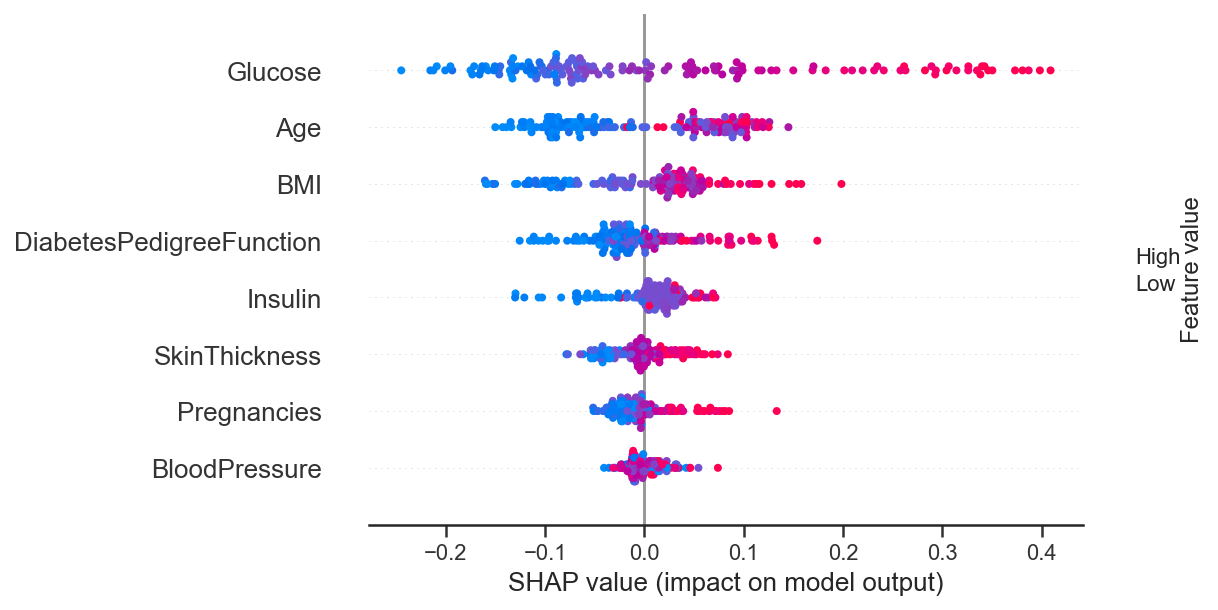

In [197]:
# a global explanation
shap.summary_plot(
    shap_values[cls_idx], 
    X_test_pp
)

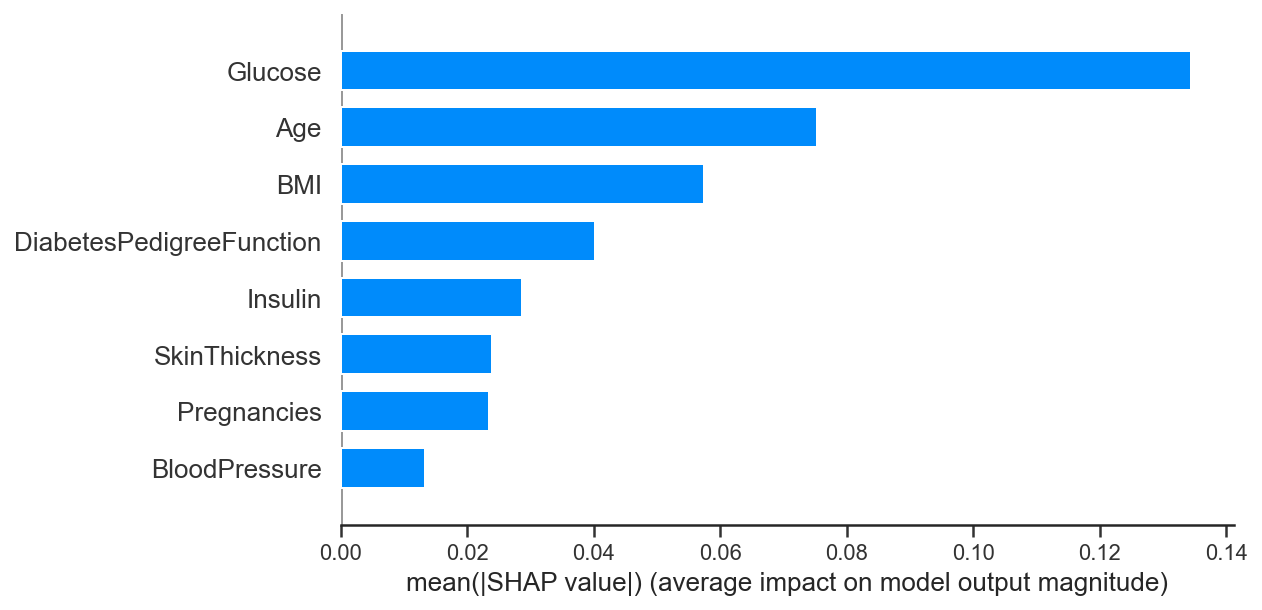

In [189]:
# a global explanation: mean absolute SHAP as feature importance
shap.summary_plot(shap_values[cls_idx], X_test_pp, plot_type="bar")

In [204]:
row_idx = 64

In [205]:
shap.force_plot(
    explainer.expected_value[cls_idx], 
    shap_values[cls_idx][row_idx], 
    pd.Series(
        X_test_pp.iloc[row_idx],
        index=all_cols
    )
)

In [190]:
shap.force_plot(explainer.expected_value[cls_idx], shap_values[cls_idx], X_test_pp)